# Memento-CXG cross-dataset showcase

In [1]:
import tiledb
import tiledbsoma as soma
from somacore import ExperimentAxisQuery, AxisQuery
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import itertools
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import time
import scanpy as sc
import statsmodels.api as sm
pd.set_option('display.max_rows', 500)

In [2]:
from statsmodels.stats.multitest import fdrcorrection

In [3]:
import sys
sys.path.append('/home/ubuntu/Github/scrna-parameter-estimation/')
import memento

In [4]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'large',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [6]:
cube_path = '/home/ubuntu/Github/memento-cxg/'
save_path = '/home/ubuntu/Data/mementocxg/'

### Identify datasets

Pick datasets with a few donors, see if combining datasets improve power.

In [7]:
dataset_ids_to_query = ['c7775e88-49bf-4ba2-a03b-93f00447c958', '218acb0f-9f2f-4f76-b90b-15a4b7c7f629', '4c4cd77c-8fee-4836-9145-16562a8782fe']
dataset_query = '('
for idx, di in enumerate(dataset_ids_to_query): 
    dataset_query += f'dataset_id == "{di}" '
    if idx != len(dataset_ids_to_query)-1:
        dataset_query += 'or '
dataset_query += ')'

celltypes_to_query = [
    'conventional dendritic cell',
    'plasmacytoid dendritic cell',
    'conventional dendritic cell',
    'plasmacytoid dendritic cell, human',
    'dendritic cell',
    'dendritic cell, human',
    'myeloid dendritic cell',
    'plasmacytoid dendritic cell']
celltype_query = '('
for idx, ct in enumerate(celltypes_to_query): 
    celltype_query += f'cell_type == "{ct}" '
    if idx != len(celltypes_to_query)-1:
        celltype_query += 'or '
celltype_query += ')'

OBS_VALUE_FILTER_1 = dataset_query # All cells in three datasets
OBS_VALUE_FILTER_2 = celltype_query + ' and ' + celltype_query # only relevant celltypes

exp_uri = 's3://cellxgene-data-public/cell-census/2023-10-30/soma/census_data/homo_sapiens'
layer = "raw"
measurement_name = "RNA"

with soma.Experiment.open(uri=exp_uri,
                          context=soma.SOMATileDBContext().replace(tiledb_config={
                              "vfs.s3.region":"us-west-2",
                              "vfs.s3.no_sign_request":True})
                          ) as exp:

    query = exp.axis_query(measurement_name=measurement_name,
                           obs_query=AxisQuery(value_filter=OBS_VALUE_FILTER_2),
                           # Note: Must use *all* genes to compute size factors correctly, even when var filter is
                           # being used for testing
                           var_query=AxisQuery())
obs_df = query.obs().concat().to_pandas()

In [8]:
cell_counts = obs_df.groupby(['dataset_id', 'donor_id']).size().reset_index(name='count')

In [9]:
donor_counts = cell_counts.groupby('dataset_id').donor_id.size().sort_values()
relevant_datasets = donor_counts[(donor_counts >= 5) & (donor_counts < 10)].index.tolist()

### Read results and plot

In [10]:
relevant_datasets = [
    '2672b679-8048-4f5e-9786-f1b196ccfd08',
    '86282760-5099-4c71-8cdd-412dcbbbd0b9',
    '2872f4b0-b171-46e2-abc6-befcf6de6306',
    '644a578d-ffdc-446b-9679-e7ab4c919c13',
    '11ff73e8-d3e4-4445-9309-477a2c5be6f6',
    '4dd00779-7f73-4f50-89bb-e2d3c6b71b18',
    'bd65a70f-b274-4133-b9dd-0d1431b6af34',
    'b07fb54c-d7ad-4995-8bb0-8f3d8611cabe',
    '3f32121d-126b-4e8d-9f69-d86502d2a1b1',
    'a51c6ece-5731-4128-8c1e-5060e80c69e4',
    'd7dcfd8f-2ee7-4385-b9ac-e074c23ed190',
    '2d31c0ca-0233-41ce-bd1a-05aa8404b073',
    '1e5bd3b8-6a0e-4959-8d69-cafed30fe814',
    # 'cd4c96bb-ad66-4e83-ba9e-a7df8790eb12',
    '44882825-0da1-4547-b721-2c6105d4a9d1',
    '4ed927e9-c099-49af-b8ce-a2652d069333',
    '00ff600e-6e2e-4d76-846f-0eec4f0ae417',
    '105c7dad-0468-4628-a5be-2bb42c6a8ae4',
    'c5d88abe-f23a-45fa-a534-788985e93dad',
    # 'ed5d841d-6346-47d4-ab2f-7119ad7e3a35',
    '53d208b0-2cfd-4366-9866-c3c6114081bc',
    '3de0ad6d-4378-4f62-b37b-ec0b75a50d94',
    '574e9f9e-f8b4-41ef-bf19-89a9964fd9c7',
    '1a2e3350-28a8-4f49-b33c-5b67ceb001f6',
    'd3a83885-5198-4b04-8314-b753b66ef9a8']

In [21]:
def draw_qq(df_input, thresh=1000, color='gray'):
    
    df = df_input[df_input[f'pval'] != 1.00].copy()
    df = (df[df[f'coef'].abs() < thresh])
    pvals = df[f'pval'].sort_values().values
    pvals = pvals[np.isfinite(pvals)]
    unif = np.linspace(1e-6, 1, len(pvals))
    # plt.scatter(unif, pvals, s=1)
    plt.scatter(-np.log10(unif), -np.log10(pvals), s=(5 if color=='cyan' else 0.3), color=color)
    # plt.plot(-np.log10(unif), -np.log10(unif), color='k')



In [22]:
result_fnames = ['rare_ct_whole.csv'] + [f'rare_ct_{d_id}.csv' for d_id in relevant_datasets]
names = ['whole'] + relevant_datasets

In [23]:
all_results = []
common_genes = set()
for name, fname in zip(names, result_fnames):
    
    res = pd.read_csv(save_path + fname).dropna()
    if res.shape[0] == 0:
        continue
    res = res.set_index('feature_id')
    if name == 'whole':
        common_genes = set(res.index)
    else:
        common_genes = common_genes & set(res.index)
    res['dataset'] = name
    all_results.append(res)
    # plt.ylim(-1, 10)
all_results = pd.concat(all_results).dropna().loc[list(common_genes)]

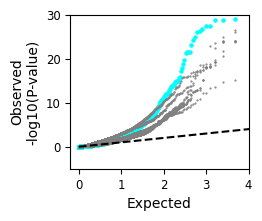

In [26]:
plt.figure(figsize=(2.3,2))
for name in names:

    draw_qq(all_results.query(f'dataset == "{name}" & pval > 1e-31'), color='cyan' if name == 'whole' else 'gray')


# draw_qq(all_results.query('dataset == "d1"'))
# draw_qq(all_results.query('dataset == "d2"'))
# draw_qq(all_results.query('dataset == "d3"'))
plt.ylim(-5, 30)
plt.xlim(-0.2, 4)
plt.plot([0,8], [0, 8],'--', color='k', );
plt.xlabel('Expected'); plt.ylabel('Observed\n-log10(P-value)')
plt.savefig('cxg_qq.png', bbox_inches='tight')